In [1]:
# %pip install mysql 
# %pip install numpy sentence_transformers textstat language_tool_python mysql 
# %pip install seaborn

In [24]:
chat_ids = [
    50,52,53,54
]

In [25]:
import asyncio
from sqlalchemy.ext.asyncio import create_async_engine, AsyncSession
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text

from openai import OpenAI


In [26]:
import chromadb
from chromadb.config import Settings as ChromaSettings

In [27]:
import os 

from dotenv import load_dotenv

load_dotenv()

True

In [28]:
def get_chroma_client():
    """
    Get a ChromaDB client
    """
    return chromadb.HttpClient(
        host=os.getenv("CHROMA_HOST"),
        port=os.getenv("CHROMA_PORT"),
        settings=ChromaSettings(
            chroma_client_auth_provider="chromadb.auth.token_authn.TokenAuthClientProvider",
            chroma_client_auth_credentials=os.getenv("CHROMA_TOKEN"),
        ),
    )

In [29]:
engine = create_async_engine(os.getenv("DB_CONNECTION"), echo=False)
SessionLocal = sessionmaker(engine, expire_on_commit=False, class_=AsyncSession)
Base = declarative_base()

/var/folders/hz/3q2hm1rd5h3dlkgh6ph5b17h0000gn/T/ipykernel_50354/4078502320.py:3: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


In [30]:
openai_client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

def get_openai_embedding(text):
    """
    Fetches the embedding for the provided text using OpenAI's embedding model.
    
    :param text: The text to embed.
    :return: The embedding as a list of floats.
    """
    response = openai_client.embeddings.create(
        model="text-embedding-ada-002",
        input=text,
    )
    return response.data[0].embedding

In [31]:
async def get_ai_response_from_db(chat_id: str = None):
    """
    Connects to MySQL asynchronously and fetches an AI-generated response.
    """
    async with SessionLocal() as session:
        result = await session.execute(text(f"SELECT content FROM message WHERE role = 'ASSISTANT' and chat_id = {chat_id};"))
        response = result.fetchall()
        return response if response else {}
    

In [32]:
chroma_client = get_chroma_client()

In [33]:
evaluations = []

for chat_id in chat_ids:
    messages = await get_ai_response_from_db(chat_id)
    chroma_collection = chroma_client.get_or_create_collection("chat-" + str(chat_id))

    q = 1

    for message in messages:
        evaluation = {}
        evaluation["chat_id"] = chat_id
        if chat_id == 50:
            evaluation["model"] = "gpt4o"
        elif chat_id == 52:
            evaluation["model"] = "llama4Maverick"
        elif chat_id == 53:
            evaluation["model"] = "deepseekv3"
        elif chat_id == 54:
            evaluation["model"] = "gemini2.5pro"
        else:
            evaluation["model"] = "Unknown"

        evaluation["question"] = f"q{q}"

        q += 1


        evaluation["message"] = message[0]    
        embedding = get_openai_embedding(message[0])
        query_result = chroma_collection.query(
            query_embeddings=[embedding],
            n_results=1,
        )
        evaluation["similarity_score"]  = (1 - query_result["distances"][0][0]) * 100

        if query_result["distances"][0][0] < 0.1:
            evaluation["relevance"] = "Highly relevant"
        elif query_result["distances"][0][0] < 0.3:
            evaluation["relevance"] = "Moderately relevant"
        else:
            evaluation["relevance"] = "Not relevant"

        evaluations.append(evaluation)

        

In [34]:
import pandas as pd

df = pd.DataFrame(evaluations)

In [35]:
df

,chat_id,model,question,message,similarity_score,relevance
0,50,gpt4o,q1,** \n - Open the MobilePlanner software an...,71.204761,Moderately relevant
1,52,llama4Maverick,q1,"To send the AIV from its docking position to ""...",71.490312,Moderately relevant
2,53,deepseekv3,q1,Step-by-Step Guide** \n\n#### **How to Send t...,73.142162,Moderately relevant
3,54,gemini2.5pro,q1,"Assuming MobilePlanner is running, connected t...",72.167405,Moderately relevant


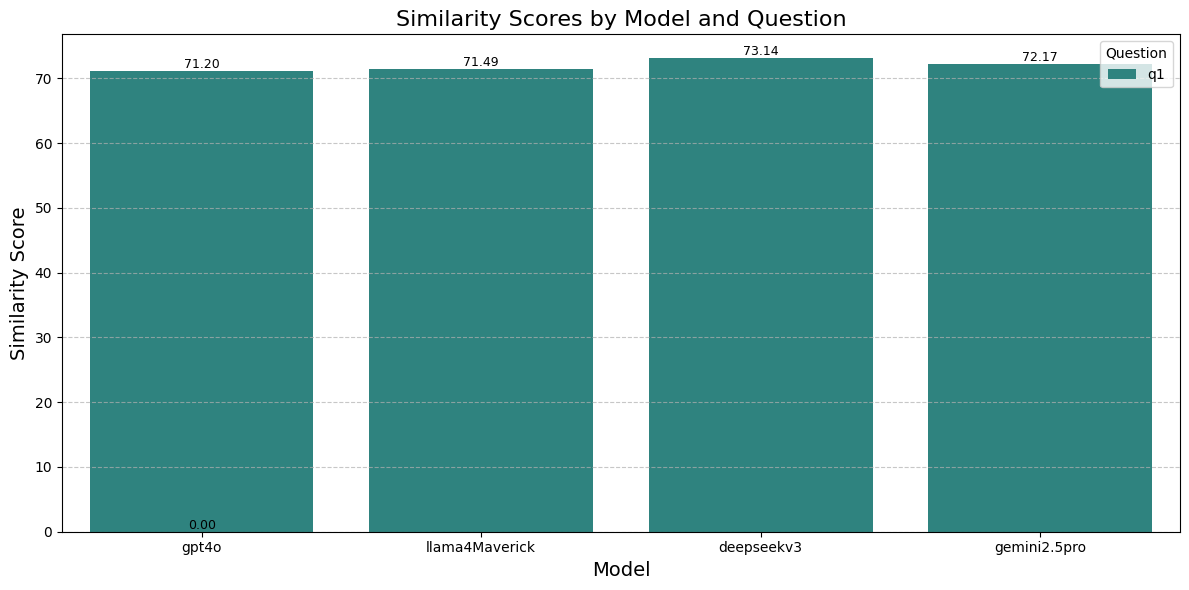

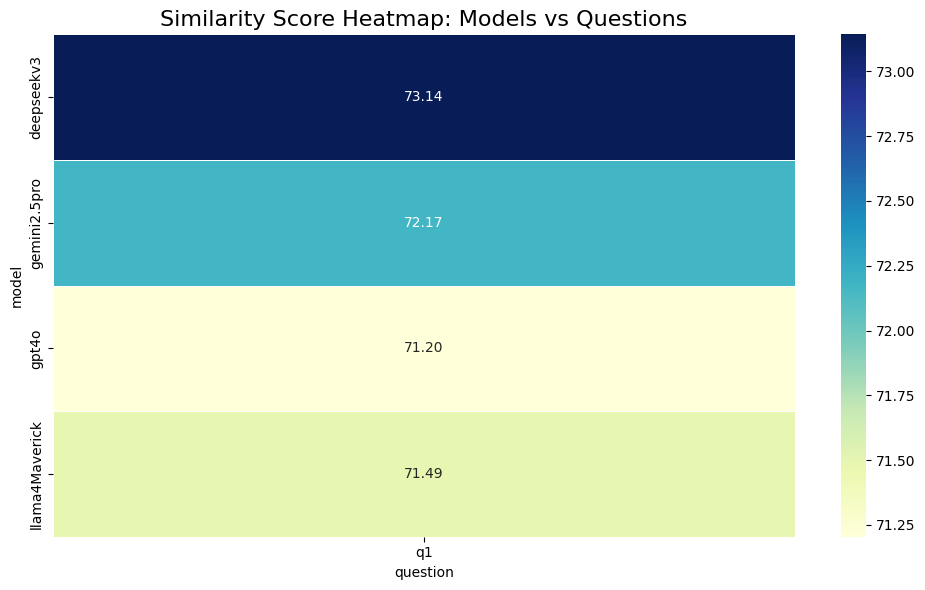

/var/folders/hz/3q2hm1rd5h3dlkgh6ph5b17h0000gn/T/ipykernel_50354/2037129357.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='similarity_score', data=model_avg, palette='Set2')


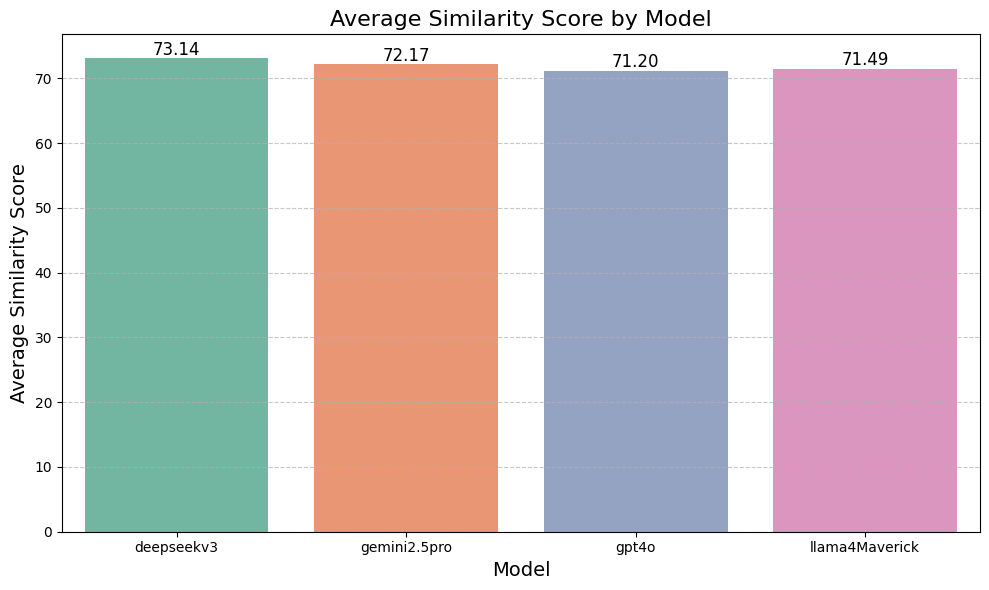

/var/folders/hz/3q2hm1rd5h3dlkgh6ph5b17h0000gn/T/ipykernel_50354/2037129357.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='model', y='similarity_score', data=df, palette='Set3')


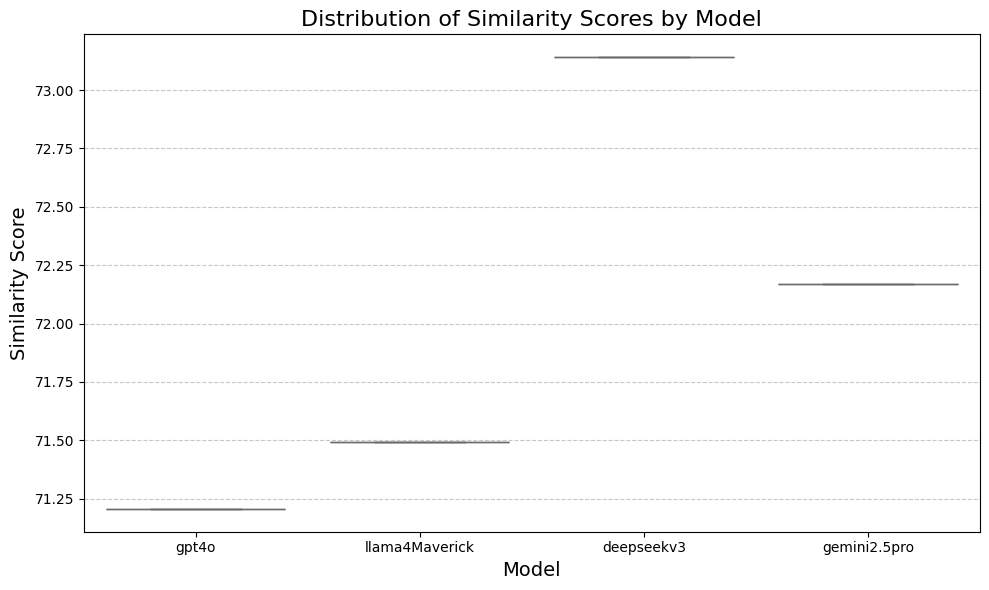

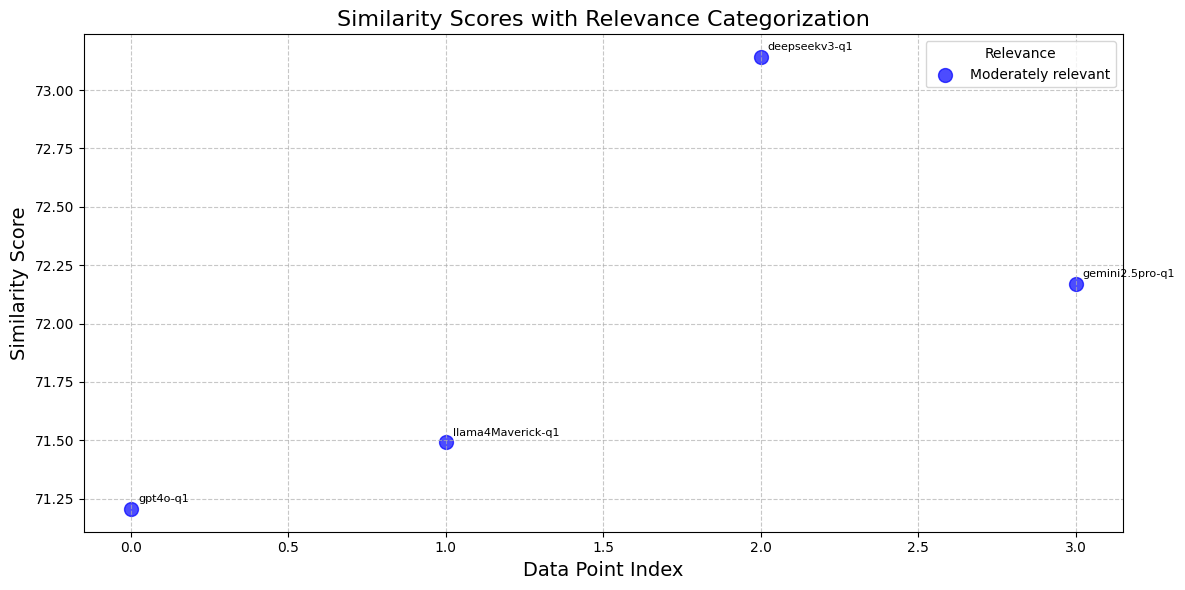

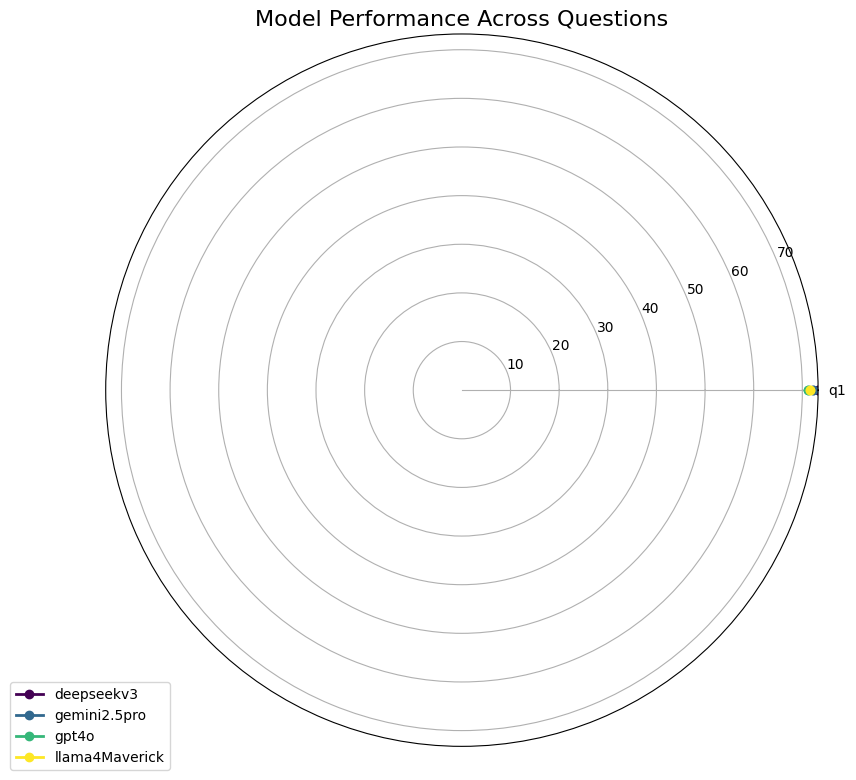

Model performance relative to overall average:
gpt4o: 71.20 (Diff: -0.80)
llama4Maverick: 71.49 (Diff: -0.51)
deepseekv3: 73.14 (Diff: +1.14)
gemini2.5pro: 72.17 (Diff: +0.17)


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create better category for relevance
df['relevance_numeric'] = df['relevance'].map({'Not relevant': 0, 'Moderately relevant': 1, 'Highly relevant': 2})

# 1. Bar chart comparing similarity scores across models and questions
plt.figure(figsize=(12, 6))
chart = sns.barplot(x='model', y='similarity_score', hue='question', data=df, palette='viridis')
plt.title('Similarity Scores by Model and Question', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Similarity Score', fontsize=14)
plt.legend(title='Question')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for p in chart.patches:
    chart.annotate(f'{p.get_height():.2f}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'bottom',
                   fontsize=9)

plt.tight_layout()
plt.savefig('model_question_comparison.png', dpi=300)
plt.show()

# 2. Heatmap to visualize the matrix of models vs questions
pivot_table = df.pivot_table(values='similarity_score', index='model', columns='question')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=.5)
plt.title('Similarity Score Heatmap: Models vs Questions', fontsize=16)
plt.tight_layout()
plt.savefig('model_question_heatmap.png', dpi=300)
plt.show()

# 3. Grouped bar chart for models with average similarity scores
plt.figure(figsize=(10, 6))
model_avg = df.groupby('model')['similarity_score'].mean().reset_index()
sns.barplot(x='model', y='similarity_score', data=model_avg, palette='Set2')
plt.title('Average Similarity Score by Model', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Average Similarity Score', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add average values on top of bars
for i, v in enumerate(model_avg['similarity_score']):
    plt.text(i, v + 0.5, f'{v:.2f}', ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('model_avg_scores.png', dpi=300)
plt.show()

# 4. Box plot to show the distribution of similarity scores for each model
plt.figure(figsize=(10, 6))
sns.boxplot(x='model', y='similarity_score', data=df, palette='Set3')
plt.title('Distribution of Similarity Scores by Model', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Similarity Score', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model_score_distribution.png', dpi=300)
plt.show()

# 5. Scatter plot with relevance categorization
plt.figure(figsize=(12, 6))
relevance_colors = {0: 'red', 1: 'blue', 2: 'green'}
for relevance, group in df.groupby('relevance_numeric'):
    plt.scatter(group.index, group['similarity_score'], 
                label=f"{'Not relevant' if relevance==0 else 'Moderately relevant' if relevance==1 else 'Highly relevant'}", 
                color=relevance_colors[relevance], s=100, alpha=0.7)

plt.title('Similarity Scores with Relevance Categorization', fontsize=16)
plt.xlabel('Data Point Index', fontsize=14)
plt.ylabel('Similarity Score', fontsize=14)
plt.legend(title='Relevance')
plt.grid(linestyle='--', alpha=0.7)

# Add model and question annotations
for i, row in df.iterrows():
    plt.annotate(f"{row['model']}-{row['question']}", 
                 (i, row['similarity_score']),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=8)

plt.tight_layout()
plt.savefig('similarity_relevance.png', dpi=300)
plt.show()

# 6. Radar chart for comparing models across questions
def radar_chart(df):
    # Prepare the data
    pivot = df.pivot_table(values='similarity_score', index='model', columns='question').fillna(0)
    
    # Get categories and values
    categories = pivot.columns.tolist()
    models = pivot.index.tolist()
    
    # Create the figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, polar=True)
    
    # Set the angles for each category
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    # Add categories to the chart
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    
    # Plot each model
    colors = plt.cm.viridis(np.linspace(0, 1, len(models)))
    
    for i, model in enumerate(models):
        values = pivot.loc[model].tolist()
        values += values[:1]  # Close the loop
        ax.plot(angles, values, 'o-', linewidth=2, color=colors[i], label=model)
        ax.fill(angles, values, color=colors[i], alpha=0.25)
    
    plt.title('Model Performance Across Questions', fontsize=16)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.tight_layout()
    plt.savefig('model_radar_chart.png', dpi=300)
    plt.show()

radar_chart(df)

# 7. Additional analysis - model performance difference from average
print("Model performance relative to overall average:")
overall_avg = df['similarity_score'].mean()
for model in df['model'].unique():
    model_avg = df[df['model'] == model]['similarity_score'].mean()
    diff = model_avg - overall_avg
    print(f"{model}: {model_avg:.2f} (Diff: {diff:+.2f})")